# Overfitting and Regularization

## Imports

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [52]:
set_config(display='diagram')

## Settings

In [53]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [54]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

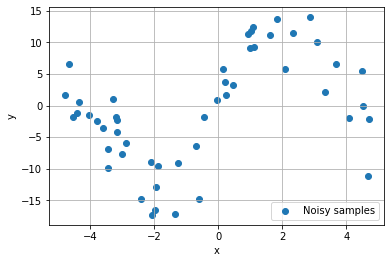

In [55]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

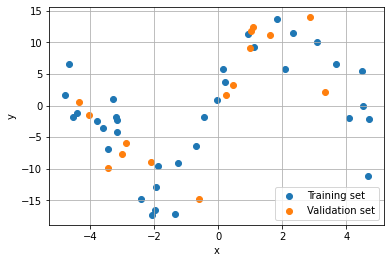

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [57]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [58]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1,5],
    [3,5],
    [4,5],
])

array([[  1.,   5.,   1.,   5.,  25.,   1.,   5.,  25., 125.,   1.,   5.,
         25., 125., 625.],
       [  3.,   5.,   9.,  15.,  25.,  27.,  45.,  75., 125.,  81., 135.,
        225., 375., 625.],
       [  4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125., 256., 320.,
        400., 500., 625.]])

In [59]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

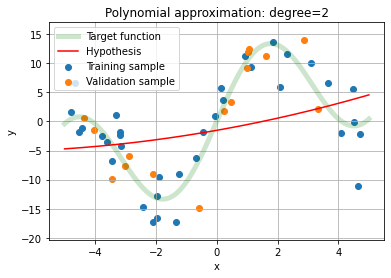

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])


In [60]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))
print(make_model(degree=2))


### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

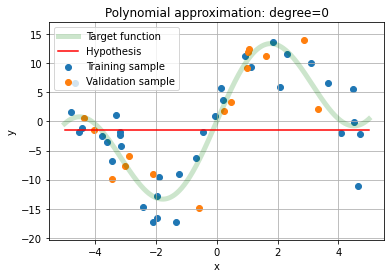

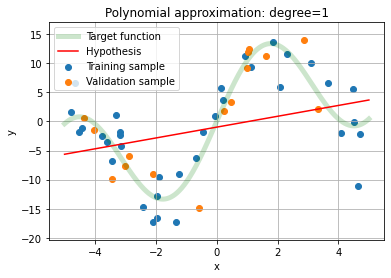

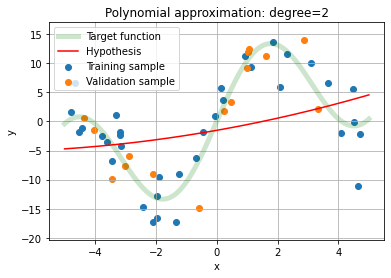

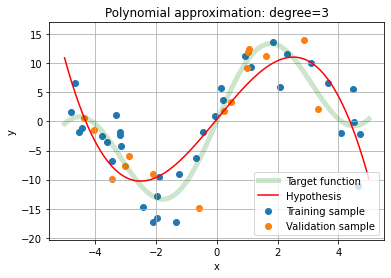

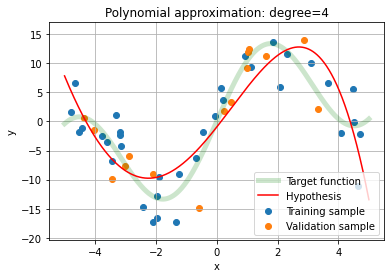

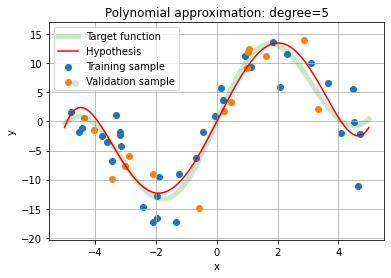

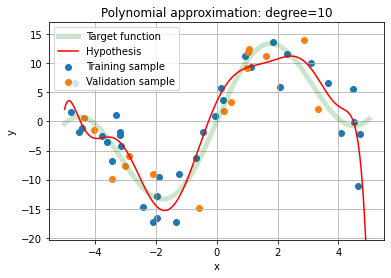

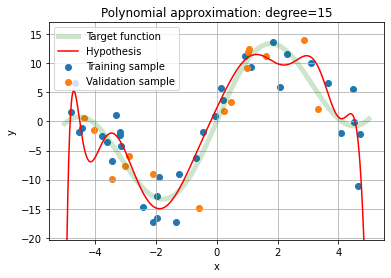

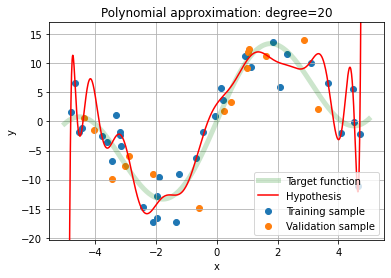

In [61]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

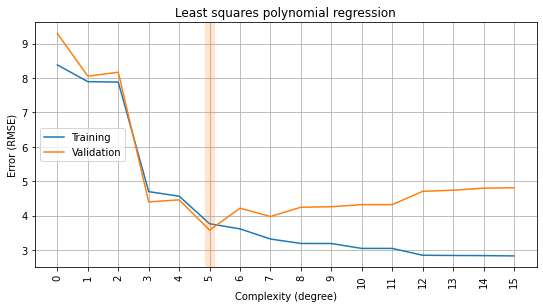

In [62]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [63]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

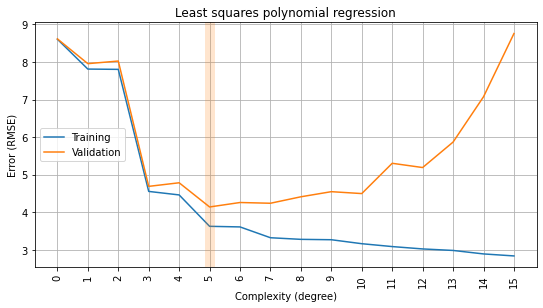

In [64]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [65]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

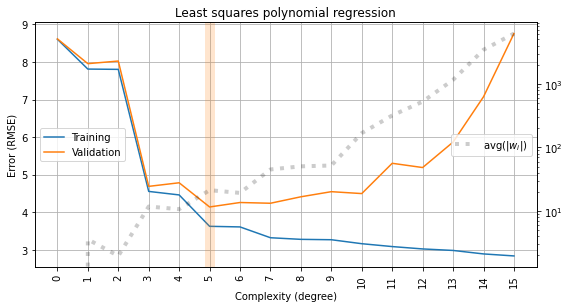

In [66]:
rmse_train, rmse_valid, avg_coef = [], [], []

for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')



### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

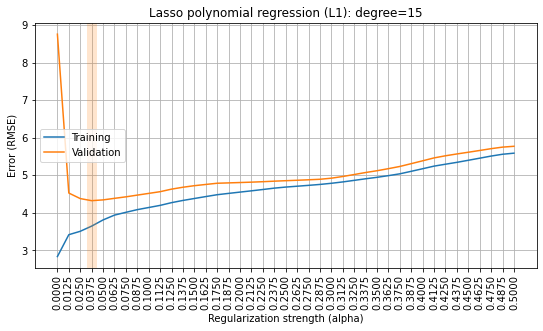

In [67]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

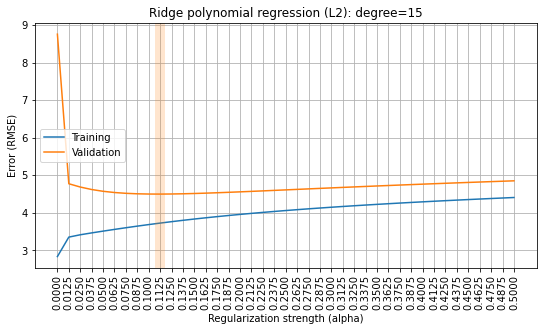

In [68]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [69]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])
print(data['feature_names'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [70]:
X_diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

## Исследование

Построим модель на всех данных используя кроссвалидацию.

Посмотрим на результат нашей обученой модели в зависимости от степени полинома. Так же посмотрим на сумму коэффицентов этих моделей.

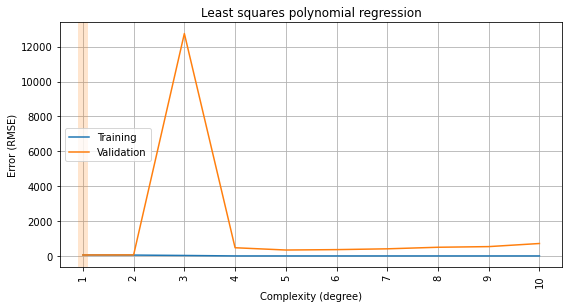

In [71]:
# your findings/conclusions

DEGREES = np.linspace(1, 10, 10, dtype=int)
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', title='Least squares polynomial regression')


Первая степень (degree==1) показала наилучшую ошибку среди всех степеней от 1 до 15. 

Так же у нас получается не было найдено недообученных моделей, но зато было построено много моделей которые были переобучены. Это модели с степенями от 2 до 15. Так же на степени равной трём видим значительное увеличении ошибки на тестовых данных.

Видим что после степени degree==1 идёт увеличение разницы ошибки RMSE между тренировачными данными и тестовыми, что является доказательством переобучения моделей.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Так как на степени полинома 15 у нас не могут обработаться все данные из набора, то было разрешено полиномизировать часть набора и соеденить с переменными которые мы не полиноминизировали.

Для этого перепишем функцию make_model, убрав от туда PolynomialFeatures, которую будем использовать вне данной функции

In [72]:
def make_model(alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000,tol=1e-2)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

Сделаем полином только на части данных и соеденим с переменными, которые не участвовали в построении полинома.

Посмотрим на результаты моделей Lasso polynomial regression (L1) в зависимости от значения alpha. Так же выведем средний модуль коэффициентов этих моделей.

#### L1

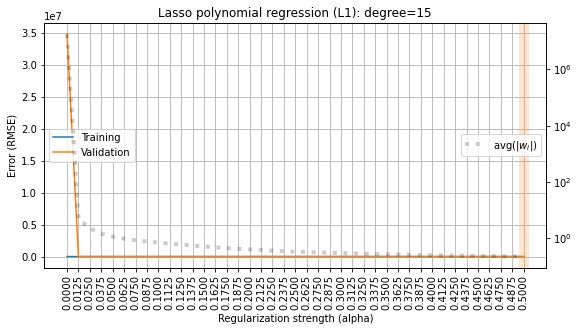

In [73]:
rmse_train, rmse_valid , avg_coef= [], [], []

all_features=pd.concat([X_diabetes[['bp','s1','s2', 's3', 's4', 's5', 's6']], pd.DataFrame(PolynomialFeatures(15, include_bias=(degree == 0)).fit_transform(X_diabetes[['age','sex','bmi']]))], axis=1)

for alpha in ALPHAS:  
    results = cross_validate(make_model(penalty='L1', alpha=alpha), 
                             all_features, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            
            for model in results['estimator']
        ]))
    
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')


Как можем наблюдать регуляризация Lasso действительно ограничивает веса модели при увеличении значения alpha.
Наименьшая ошибка наблюдается в alpha=0.5 в диапазоне ALPHAS от 0 до 0.5

#### L2

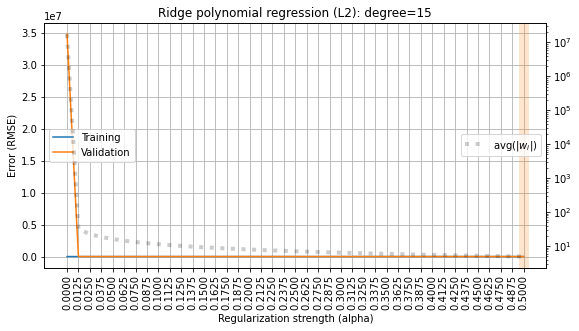

In [74]:
## your code
rmse_train, rmse_valid, avg_coef= [], [], []
all_features=pd.concat([X_diabetes[['bp','s1','s2', 's3', 's4', 's5', 's6']], pd.DataFrame(PolynomialFeatures(15, include_bias=(degree == 0)).fit_transform(X_diabetes[['age','sex','bmi']]))], axis=1)

for alpha in ALPHAS:    
    results = cross_validate(make_model( penalty='L2', alpha=alpha), 
                             all_features, y_diabetes, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

Тут идентичные результаты. Регуляризация Ridge действительно ограничивает веса модели при увеличении значения alpha.
И так же наименьшая ошибка наблюдается в alpha=0.5 в диапазоне ALPHAS от 0 до 0.5

#### Summary

Эмпирически было доказано что регуляризация уменьшает веса модели и делает ее лучше до какого-то момента.

Как можем наблюдать регуляризация Lasso и регуляризация Ridge действительно ограничивают веса модели при увеличении значения alpha.

Наилучший результат (наименьший результат ошибки RMSE) модели с регуляризацией Lasso и регуляризацией Ridge (на промежутке ALPHAS от 0 до 0.5) показали с alpha==0.5.

Глядя на графики, можно с увереностью сказать что регуляризация Lasso и регуляризация Ridge помогаяет урегулировать веса моделей.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

### Исследование

Построим заново модели с L1  и L2 и запишем в список null_coef количество нулевых коэффициентов для всех alpha, которые подбираются для модели.

Это необходимо чтобы мы оценили количество нулевых коэффициентов для L1 и L2. Так как мы используем кроссвалидацию у нас покажет точную картину, так как подобранных коэффициентов будет большее количество чем если бы мы не использовали кроссвалидацию.

Построим модель и отобразим на графике количество нулевых коэфициентов модели для каждой alpha

#### L1

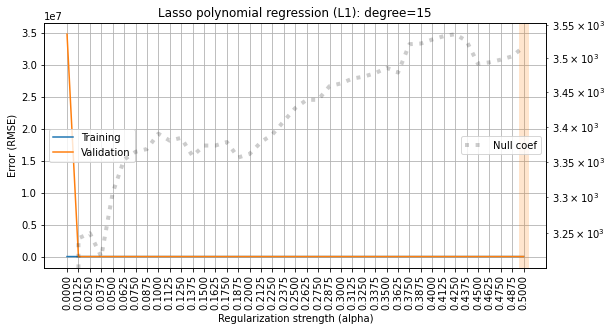

Количество нулевых коэфициентов: [0, 3243, 3250, 3218, 3306, 3353, 3364, 3368, 3390, 3380, 3384, 3358, 3373, 3373, 3378, 3356, 3361, 3378, 3389, 3408, 3427, 3439, 3439, 3459, 3463, 3470, 3473, 3478, 3486, 3479, 3521, 3522, 3528, 3533, 3536, 3526, 3492, 3494, 3498, 3503, 3517]


In [75]:
## your code
rmse_train, rmse_valid , null_coef,all_coef= [], [], [],[]
num_all_coef=0
uuuu=pd.concat([X_diabetes[['bp','s1','s2', 's3', 's4', 's5', 's6']], pd.DataFrame(PolynomialFeatures(15, include_bias=(degree == 0)).fit_transform(X_diabetes[['age','sex','bmi']]))], axis=1)
for alpha in ALPHAS:  
    results = cross_validate(make_model(penalty='L1', alpha=alpha), 
                             uuuu, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    #print(results)
    
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
    null_co=0
    
    for model in results['estimator']:
        uuu=model['reg'].coef_
        its_null=uuu[uuu==0].size
        null_co=null_co+its_null
        num_all_coef=num_all_coef+uuu.size
    null_coef.append(null_co)

    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=null_coef, custom_label='Null coef',
                   title='Lasso polynomial regression (L1): degree=15')

print('Количество нулевых коэфициентов:',null_coef)

Как видим когда alpha не равно нулю, то появляется большое количество нулевых коэффициентов, при этом данное количество возрастает при увеличении alpha.

Проверим процентное количество нулевых коэфициентов среди всех коэффициентов данной модели.

In [76]:

print('Процент нулевых коэффициентов от всех коэффициентов с регуляризацией Lasso:',(sum(null_coef)/num_all_coef)*100,'%')


Процент нулевых коэффициентов от всех коэффициентов с регуляризацией Lasso: 81.24918402468695 %


Как можем видеть целых 81.25% коэффициентов в нашей модели оказались нулевыми. Таким образом мы можем отобрать только нужные нам переменные для построения модели.

Иследуем на количество нулевых коэфиициентов L2:

#### L2

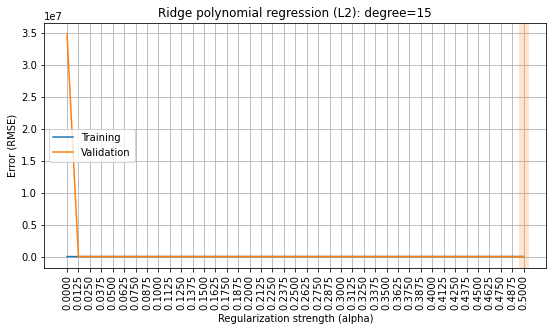

Количество нулевых коэфициентов: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [77]:
## your code

rmse_train, rmse_valid , null_coef,all_coef= [], [], [],[]
num_all_coef=0
uuuu=pd.concat([X_diabetes[['bp','s1','s2', 's3', 's4', 's5', 's6']], pd.DataFrame(PolynomialFeatures(15, include_bias=(degree == 0)).fit_transform(X_diabetes[['age','sex','bmi']]))], axis=1)
for alpha in ALPHAS:  
    results = cross_validate(make_model(penalty='L2', alpha=alpha), 
                             uuuu, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    #print(results)
    
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
    null_co=0
    
    for model in results['estimator']:
        uuu=model['reg'].coef_
        its_null=uuu[uuu==0].size
        null_co=null_co+its_null
        num_all_coef=num_all_coef+uuu.size
    null_coef.append(null_co)

    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')

print('Количество нулевых коэфициентов:',null_coef)

Как можем заметить не было найдено ни одного нулевого коэффициента. Таким образом регуляризация Ridge не зануляет коэффициенты, как регурялизация Lasso.

#### Summary

Было эмпирически выяснено, что регурялизация Lasso зануляет коэффициенты

Таким образом например в нашей модели L2 обнулилось 81.25% коэффициентов. Довольно большое количество.

При этом количпество нулевых коэффициентов возрастало при увеличении alpha.

В свою очередь регуляризация Ridge не обнулила ни одного коэффициента.

Таким образом можно уверено сказать что регурялизацию Lasso можно использовать для выбора переменных для построения моделей.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [78]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()
for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


## Исследование

Как можем увидеть выше наши переменные имеют очень разный диапазон:
* feature 0: от -0.05 до 0.05
* feature 1: от -494.87 до 493.57
* feature 2: от -2.35 до  213.31

Слишком сильно разные и в данном случае очень плохо могут работать модели линейной регрессии с регурялизацией (что мы проверим дальше!!!)

Посмотрим на данные которые нам предоставлены:

In [79]:
X_hw

array([[-1.25459881e-02, -3.84945434e+02,  8.06670932e+01],
       [ 4.50714306e-02,  1.09066539e+02,  1.82952436e+02],
       [ 2.31993942e-02, -3.66609036e+02, -2.35345655e+00],
       [ 9.86584842e-03, -2.59410380e+02,  1.69965849e+02],
       [-3.43981360e-02, -1.72860944e+02,  6.60496439e+01],
       [-3.44005480e-02,  3.59137491e+02,  1.76449257e+02],
       [-4.41916388e-02,  1.66090213e+02,  1.61060798e+02],
       [ 3.66176146e-02,  4.11622123e+01,  1.50749426e+02],
       [ 1.01115012e-02, -4.70986176e+02,  1.41406499e+02],
       [ 2.08072578e-02,  2.33748296e+02,  2.13314635e+02],
       [-4.79415506e-02, -1.05049982e+02,  7.02522165e+01],
       [ 4.69909852e-02,  3.02047119e+02,  7.09365231e+01],
       [ 3.32442641e-02, -2.45578874e+02,  6.72052927e+01],
       [-2.87660889e-02, -4.43115063e+02,  1.46257443e+02],
       [-3.18175033e-02,  3.66648641e+02,  3.50419328e+01],
       [-3.16595490e-02, -2.78971004e+02,  1.50558343e+02],
       [-1.95757757e-02, -9.50105520e+01

Как видим фичи отличаются между собой на порядки.

Посмотрим как будуты выглядеть эти данные, когда мы их отмасштабируем:

In [80]:
#StandardScaler().fit_transform(X_hw)

Как можем заметить наши данные не отличаются на порядки 10 степени как раньше

Проверим максимальные и минимальные значения:

In [81]:
#resss=StandardScaler().fit_transform(X_hw)
#for i in range(resss.shape[1]):
#    print(f'Min of feature {i}: {min(resss[:, i]):.2f}, max: {max(resss[:, i]):.2f}')

Вот это уже другое дело!

Теперь эти данные можно использовать для обучения модели.

Scaling, в нашем случае стандартизация, необходима, так она может заставить каждую функцию вносить одинаковый вклад в результат.

Пока наши данные не стандатризированы они вносят разный вклад в создании общего результата (что увидим ниже, когда будем смотреть коэффициенты данных моделей)

Еще одним преимуществом масштабирования является повышение точности. Так как модели построенные на неотмасштабированных данных могут быть неточными. Проверим это:

#### L1

Проверим на модели которая у нас есть.

Возьмем первый случай, когда у нас данные отскалированы. Проверим на всех alpha и выведем коэффициенты для данных alpha:

Alpha: 0.0
Alpha: 0.0125
Alpha: 0.025
Alpha: 0.037500000000000006
Alpha: 0.05
Alpha: 0.0625
Alpha: 0.07500000000000001
Alpha: 0.08750000000000001
Alpha: 0.1
Alpha: 0.1125
Alpha: 0.125
Alpha: 0.1375
Alpha: 0.15000000000000002
Alpha: 0.1625
Alpha: 0.17500000000000002
Alpha: 0.1875
Alpha: 0.2
Alpha: 0.21250000000000002
Alpha: 0.225
Alpha: 0.23750000000000002
Alpha: 0.25
Alpha: 0.2625
Alpha: 0.275
Alpha: 0.28750000000000003
Alpha: 0.30000000000000004
Alpha: 0.3125
Alpha: 0.325
Alpha: 0.3375
Alpha: 0.35000000000000003
Alpha: 0.36250000000000004
Alpha: 0.375
Alpha: 0.3875
Alpha: 0.4
Alpha: 0.41250000000000003
Alpha: 0.42500000000000004
Alpha: 0.4375
Alpha: 0.45
Alpha: 0.4625
Alpha: 0.47500000000000003
Alpha: 0.48750000000000004
Alpha: 0.5


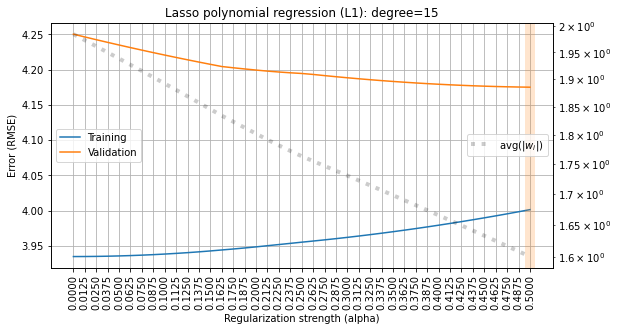

[1.984767254889243, 1.9732003840045595, 1.9616335634064064, 1.9500667428082532, 1.9384999222101005, 1.9269331016119473, 1.9153662810137937, 1.903799460415641, 1.8922326398174873, 1.8806658192193342, 1.8690989986211815, 1.8575321780230283, 1.845965357424875, 1.8343985368267224, 1.8238762667086093, 1.8133791245459157, 1.8028804829516982, 1.792381472992869, 1.7825367701734856, 1.773106026004252, 1.7640017222622295, 1.7556740671375946, 1.7475309762119142, 1.739387885286234, 1.731244794360554, 1.723101703434874, 1.7149586125091936, 1.7068155215835135, 1.6986724306578331, 1.6905293397321532, 1.682386248806473, 1.6742431578807928, 1.6661000669551125, 1.6579569760294324, 1.6498138851037525, 1.6416707941780722, 1.6335277032523918, 1.625384612326712, 1.6172415235126898, 1.6090984319041681, 1.600955340295646]


In [82]:
## your code
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=500000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=500000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])
rmse_train, rmse_valid , avg_coef= [], [], []



for alpha in ALPHAS:  
    print('Alpha:',alpha)
    results = cross_validate(make_model(degree=15,penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    #print(results)
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_)) 
            for model in results['estimator']
        ]))
    
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')
print(avg_coef)

Как можем заметить наши коэффициенты не отличаются довольно сильно (в порядках десятой степени)

Так же что важно, наша модель работает отлично и регурялизация Lasso отлично справляется при увеличении Alpha от нуля ошибка уменьшается.

Проверим данную модель, но уже без нормализации StandardScaler() и выясним неужели это так важно:

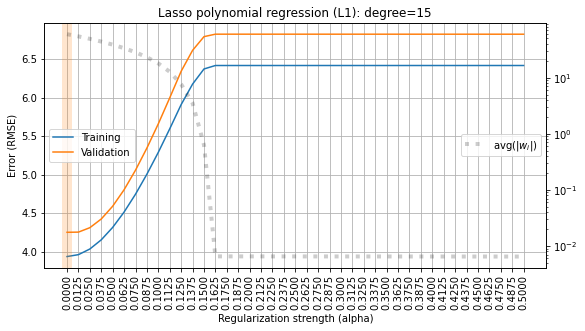

In [83]:
## your code
def make_model_1(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=500000,tol=1e-2)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=500000) 
    
    
    return Pipeline([
        ('reg', regressor)
    ])
rmse_train_1, rmse_valid_1 , avg_coef_1= [], [], []


null_koef=0
for alpha in ALPHAS:  

    results = cross_validate(make_model_1(degree=15,penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    #print(results)
    rmse_train_1.append(-np.mean(results['train_score']))
    rmse_valid_1.append(-np.mean(results['test_score']))
    avg_coef_1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_)) 
            #model['reg'].coef_.max()
            
            for model in results['estimator']
        ]))
   
    
    
plot_fitting_graph(ALPHAS, rmse_train_1, rmse_valid_1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

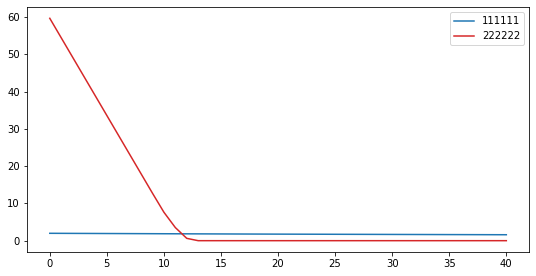

In [84]:
plt.figure(figsize=(9,4.5))
plt.plot(avg_coef,label='111111')
plt.plot(avg_coef_1,label='222222',color='C3')
plt.legend(loc='upper right')
#plt.ylim(0,2)

Как можем заметить у нас до Alpha равным 0.1375 коэффициенты имеют большую разницу в порядках, то есть они вносят разный вклад в создании общего результата, а это неправильно.

Но так же можем заметить,что модель которая была построена на неотмасштабированных данных  не точно отображает картину, так как регурялизация Lasso  не работает, так как лучший результат ошибки при Alpha=0, а после того как добавляем Alpha, то модель становиться переобученной, так как увеличивается ошибка, а это неверно.

Глядя на кожэффициенты двух моделей с регурялизацией Lasso, построенных на отмасштабированных данных и не отмасштабированных данных, можем уверенно скачать, что:
* модель на данных, которые неотмасштабированы не точна
* коэффициенты имеют разный порядок и вносят разный вклад в общий результат, что не является хорошим результатом

Проверим это же на регурялизации Ridge:

#### L2

Проверим данную модель для начала с нормализацией StandardScaler():

Alpha: 0.0
Coef: [ 4.583961    0.49492412 -0.19739922]
Coef: [ 5.16272574 -0.1345173  -0.55148674]
Coef: [ 5.26832245  0.24719329 -0.58254685]
Coef: [ 5.23977516 -0.12899677 -0.70137687]
Coef: [ 5.27963789  0.24280929 -0.95583613]
Alpha: 0.0125
Coef: [ 4.58248891  0.49476721 -0.19762258]
Coef: [ 5.16110625 -0.13464034 -0.55137382]
Coef: [ 5.2666606   0.24696467 -0.58239959]
Coef: [ 5.23811113 -0.12917922 -0.70110259]
Coef: [ 5.27799431  0.24287424 -0.95564338]
Alpha: 0.025
Coef: [ 4.58101781  0.49461041 -0.1978456 ]
Coef: [ 5.15948779 -0.13476321 -0.55126094]
Coef: [ 5.26499981  0.24673628 -0.5822524 ]
Coef: [ 5.23644817 -0.12936142 -0.70082854]
Coef: [ 5.27635177  0.24293906 -0.95545068]
Alpha: 0.037500000000000006
Coef: [ 4.57954768  0.49445372 -0.19806829]
Coef: [ 5.15787036 -0.13488589 -0.5511481 ]
Coef: [ 5.26334007  0.24650814 -0.58210529]
Coef: [ 5.23478629 -0.12954335 -0.70055471]
Coef: [ 5.27471026  0.24300374 -0.95525803]
Alpha: 0.05
Coef: [ 4.57807853  0.49429714 -0.19829066

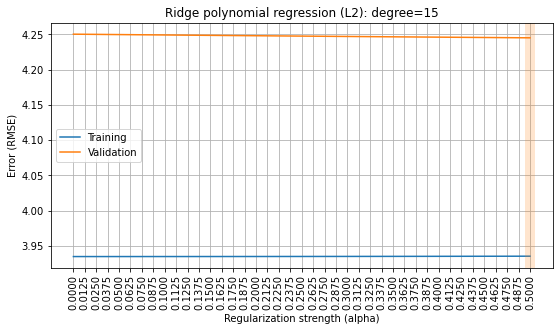

In [85]:
## your code
def make_model( alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])
rmse_train, rmse_valid, avg_coef= [], [], []

for alpha in ALPHAS:    
    print('Alpha:',alpha)
    results = cross_validate(make_model( penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
    for model in results['estimator']:
        print('Coef:',model['reg'].coef_)
    
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')


Как и в результатах с регурялизацией Lasso мы можем заметить наши коэффициенты не отличаются довольно сильно (в порядках десятой степени)

Так же что важно, наша модель работает отлично и регурялизация Ridge отлично справляется при увеличении Alpha от нуля ошибка уменьшается.

Проверим данную модель, но уже без нормализации StandardScaler() и выясним неужели это так важно:

Alpha: 0.0
Coef: [ 1.64068055e+02  1.58551758e-03 -4.69773979e-03]
Coef: [ 1.81559627e+02 -4.35773681e-04 -1.10791761e-02]
Coef: [ 1.76320180e+02  8.05682355e-04 -1.11796224e-02]
Coef: [ 1.91982324e+02 -4.24617412e-04 -1.47089847e-02]
Coef: [ 1.80830862e+02  7.82970136e-04 -1.80964267e-02]
Alpha: 0.0125
Coef: [ 1.15975744e+02  1.56803676e-03 -1.06536756e-02]
Coef: [ 1.30574477e+02 -8.64064885e-04 -1.21015744e-02]
Coef: [ 1.30326322e+02  4.18926943e-04 -1.17887986e-02]
Coef: [ 1.34651359e+02 -1.04271742e-03 -1.35846319e-02]
Coef: [ 1.31839035e+02  1.23767636e-03 -1.99521198e-02]
Alpha: 0.025
Coef: [ 8.96864729e+01  1.55848103e-03 -1.39094376e-02]
Coef: [ 1.01946187e+02 -1.10455148e-03 -1.26756529e-02]
Coef: [ 1.03363516e+02  1.92200768e-04 -1.21459130e-02]
Coef: [ 1.03687537e+02 -1.37654643e-03 -1.29773807e-02]
Coef: [ 1.03734607e+02  1.49852104e-03 -2.10166470e-02]
Alpha: 0.037500000000000006
Coef: [ 7.31132347e+01  1.55245693e-03 -1.59619280e-02]
Coef: [ 8.36139364e+01 -1.25854813e-03

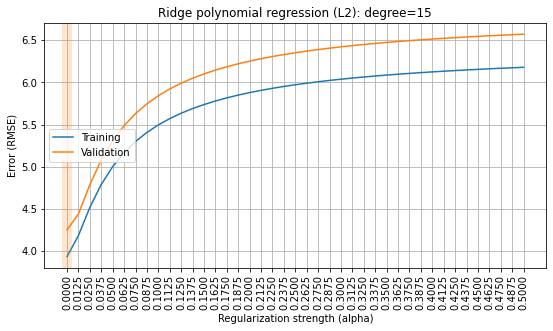

In [86]:
## your code
def make_model( alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('reg', regressor)
    ])
rmse_train, rmse_valid, avg_coef= [], [], []

for alpha in ALPHAS:    
    print('Alpha:',alpha)
    results = cross_validate(make_model( penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
    for model in results['estimator']:
        print('Coef:',model['reg'].coef_)
    
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')


Как можем заметить у нас коэффициенты имеют большую разницу в порядках, то есть они вносят разный вклад в создании общего результата, а это неправильно.

Но так же можем заметить,что модель которая была построена на неотмасштабированных данных не точно отображает картину, так как регурялизация Ridge не работает, так как лучший результат ошибки при Alpha=0, а после того как добавляем Alpha, то модель становиться переобученной, так как увеличивается ошибка, а это неверно.

#### Summary



Эмпирически было доказано:

* Scaling, в нашем случае стандартизация, необходима, так она может заставить каждую функцию вносить одинаковый вклад в результат.

* Пока наши данные не стандатризированы они вносят разный вклад в создании общего результата (что увидим ниже, когда будем смотреть коэффициенты данных моделей)

* Еще одним преимуществом масштабирования является повышение точности. Так как модели построенные на неотмасштабированных данных могут быть неточными

* регурялизация работает неточно на неотскалированных данных